# Visualize forcing before and after remapping


In [67]:
# modules
import os
import math
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

#### Control file handling

In [3]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [4]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [5]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [6]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [63]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'forcing_remapping.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Find location of shapefiles

In [29]:
# Catchment shapefile path & name
catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

In [30]:
# Specify default path if needed
if catchment_path == 'default':
    catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    catchment_path = Path(catchment_path) # make sure a user-specified path is a Path()

In [45]:
# HRU fieldname
shp_hru = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### Find the forcing files

In [11]:
# Location of merged ERA5 files
forcing_merged_path = read_from_control(controlFolder/controlFile,'forcing_merged_path')

In [12]:
# Specify default path if needed
if forcing_merged_path == 'default':
    forcing_merged_path = make_default_path('forcing/2_merged_data') # outputs a Path()
else:
    forcing_merged_path = Path(forcing_merged_path) # make sure a user-specified path is a Path()

In [24]:
# Find files in folder
forcing_source_files = [forcing_merged_path/file for file in os.listdir(forcing_merged_path) if os.path.isfile(forcing_merged_path/file) and file.endswith('.nc')]
forcing_source_files.sort()

In [13]:
# Location for EASYMORE forcing output
forcing_basin_path = read_from_control(controlFolder/controlFile,'forcing_basin_avg_path')

In [14]:
# Specify default path if needed
if forcing_basin_path == 'default':
    forcing_basin_path = make_default_path('forcing/3_basin_averaged_data') # outputs a Path()
else:
    forcing_basin_path = Path(forcing_basin_path) # make sure a user-specified path is a Path()

In [26]:
# Find files in folder
forcing_basin_files = [forcing_basin_path/file for file in os.listdir(forcing_basin_path) if os.path.isfile(forcing_basin_path/file) and file.endswith('.nc')]
forcing_basin_files.sort()

#### Load the shapefiles and the data

In [32]:
# shapefile
catchment = gpd.read_file(catchment_path/catchment_name)

In [33]:
# netcdfs
forcing_source = xr.open_dataset(forcing_source_files[0])
forcing_basin = xr.open_dataset(forcing_basin_files[0]) 

#### Plot settings and plotting data prep

In [47]:
# What to plot?
var = 'airtemp'
time = 0

In [71]:
# color settings
vmin = math.floor(min(forcing_source[var].isel(time=time).min().values,forcing_basin[var].isel(time=time).min()))
vmax = math.ceil(max(forcing_source[var].isel(time=time).max().values,forcing_basin[var].isel(time=time).max()))

In [50]:
# map basin-averaged netcdf onto shapefile
if (forcing_basin['hruId'] == catchment[shp_hru]).all(): # check that they are in the same order (they should be)
    catchment['plot_var'] = forcing_basin[var].isel(time=time)

#### Create the figure

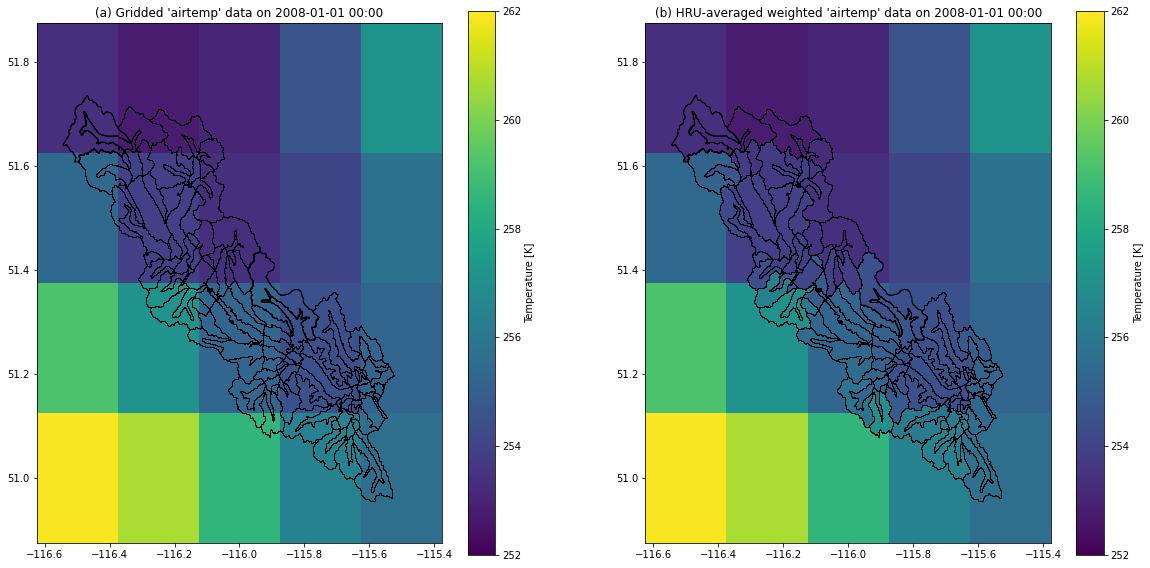

In [95]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

# source data + catchment
axId = 0
forcing_source[var].isel(time=time).plot(ax=axs[axId],vmin=vmin,vmax=vmax);
catchment.plot(color='None', edgecolor='k', ax=axs[axId]);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
time_str = forcing_source['time'].isel(time=time).dt.strftime('%Y-%m-%d %H:%M').values
axs[axId].set_title('(a) Gridded \'{}\' data on {}'.format(var,time_str))

# remapped data + catchment
axId = 1
forcing_source[var].isel(time=time).plot(ax=axs[axId],vmin=vmin,vmax=vmax);
catchment.plot(column='plot_var', edgecolor='k', ax=axs[axId],vmin=vmin,vmax=vmax);
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
time_str = forcing_source['time'].isel(time=time).dt.strftime('%Y-%m-%d %H:%M').values
axs[axId].set_title('(b) HRU-averaged weighted \'{}\' data on {}'.format(var,time_str))

# save
plt.savefig(fig_path/fig_name, bbox_inches='tight')